In [7]:
import pandas as pd
import plotnine as pn

# Get credentials
with open('/home/andreas/Dropbox/Projects/scoring-probability/credentials', 'r') as credentials_file:
    URI = credentials_file.read()
    
# Get query
with open('player-scored-query.sql', 'r') as query_file:
    query = query_file.read()
    
# Pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# Get the data
result = pd.read_sql(query, URI)

In [3]:
result.head()

,fixture_uid,team_uid,is_home,player_uid,kick_off,gameweek,season,position,played,scored,appearance_number,matches_scored,match_number,matches_scored_until_now,appearances_until_now,matches_until_now,chance_score_given_played,chance_score
0,c234ba3c78a51d023833c83b88a7fa5d,9d292673b9c1ebe339be9d36032d5e2e,1,015ab60ee2fcf75b0326823cf47fc32b,2019-08-10 12:30:00,1,1920,gk,0,0,0,0,1,0,15,15,0,0
1,d7527be5828734075d0caa9194c69437,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-08-17 15:00:00,2,1920,gk,0,0,0,0,2,0,16,17,0,0
2,282a535c1a57b5aa490b45927d41c57a,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-08-24 15:00:00,3,1920,gk,0,0,0,0,3,0,16,18,0,0
3,51c192c4d46d8e91d3068f0fd56d3e75,9d292673b9c1ebe339be9d36032d5e2e,1,015ab60ee2fcf75b0326823cf47fc32b,2019-08-31 15:00:00,4,1920,gk,0,0,0,0,4,0,15,18,0,0
4,754a58406ca76df91d773087f45f2ccd,9d292673b9c1ebe339be9d36032d5e2e,0,015ab60ee2fcf75b0326823cf47fc32b,2019-09-16 20:00:00,5,1920,gk,0,0,0,0,5,0,16,20,0,0


In [59]:
# Get some info on the player
player_query = """
select a.uid as player_uid, a.name, b.name as team_name, primary_color from data_players a join data_teams b on a.team_uid = b.uid
"""

player_info = pd.read_sql(player_query, URI)

In [60]:
result_w_info = result.merge(player_info)

## Who is the most likely to have scored each game week?

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [61]:
# Note that within a gameweek we could duplicate
s_by = ['gameweek', 'chance_score']
g_by = s_by[0]
keep = ['name', 'team_name', 'chance_score', 'gameweek', 'primary_color']
top_players = result_w_info.sort_values(s_by, ascending=[True, False]).groupby(g_by).head()[keep].sort_values(s_by)

In [77]:
def draw_barchart(gameweek):
    c = top_players.gameweek == gameweek
    colors = top_players.loc[c, 'primary_color'].replace('_', '', regex=True).tolist()
    
    ax.clear()
    ax.barh(top_players.loc[c, 'name'], top_players.loc[c, 'chance_score'], color=colors)
    
    for i, (value, name) in enumerate(zip(top_players.loc[c, 'chance_score'], top_players.loc[c, 'name'])):
        team_name = player_info.loc[player_info.name == name, 'team_name'].iloc[0]
        
        ax.text(value, i, name + ' ', size=14, weight=600, ha='right', va='bottom')  # Tokyo: name
        ax.text(value, i-.25, team_name + ' ', size=14, color='#444444', ha='right', va='baseline')  # Asia: group name
        ax.text(value, i, f'  {value:,.0f}', size=14, ha='left',  va='center')   # 38194.2: value
    
    # ... polished styles
    ax.text(1, 0.4, gameweek, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Probability to score', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Most probable goal scores each gameweek',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    plt.box(False)

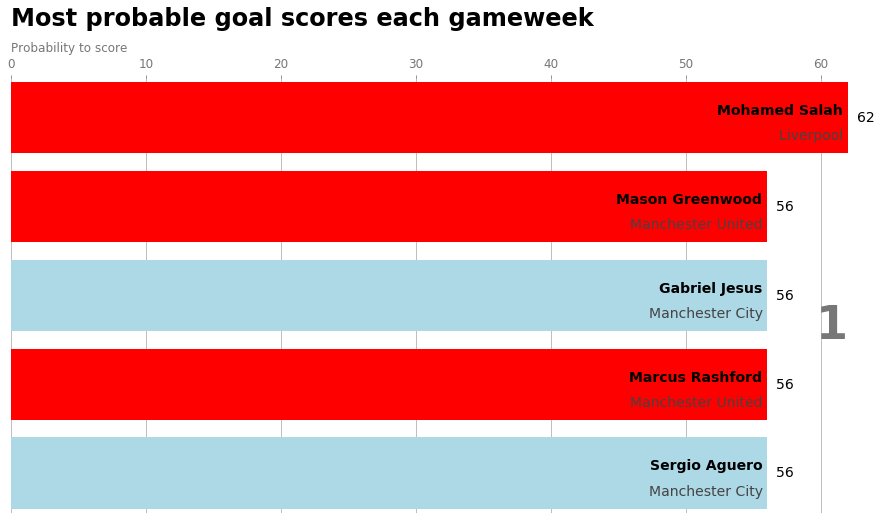

In [82]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, interval=2000, frames=range(top_players.gameweek.min(), top_players.gameweek.max()))
animator.save('scorers-race.gif', writer='imagemagick');
#HTML(animator.to_html5_video())
#HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save()

## How does the probability to score change over the season?

### How does the rank within players change over the season?